In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
!pip install pingouin


In [9]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pingouin as pg


###EDA and anomaly detection and treatment
---

In [10]:
#reading multible files from a folder:

folder_path = #put your folder path
files = os.listdir(folder_path)

#the project folder contains files with different extions, to extract only CSVs:
csv_files = [file for file in files if file.endswith('.csv')]
dfs = []

# Read each File
for filename in csv_files:
  # Create file path
  file_path = folder_path + '/' + filename
  # Read csv file
  df = pd.read_csv(file_path)
  # Append each df to the empty list
  dfs.append(df)

# Combined all dfs into one DataFrame
SEC_combined = pd.concat(dfs, ignore_index = True)


In [11]:
#check
print(len(SEC_combined))
print(SEC_combined.info())
print(SEC_combined.isna().count())
print(SEC_combined.duplicated().any())
print(SEC_combined.duplicated().sum())

1380252
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380252 entries, 0 to 1380251
Data columns (total 5 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   cell_id                  1380252 non-null  object 
 1   DateTime                 1380252 non-null  object 
 2   KWH/hh (per half hour)   1380252 non-null  float64
 3   site_id                  1380252 non-null  object 
 4   region                   1380252 non-null  object 
dtypes: float64(1), object(4)
memory usage: 52.7+ MB
None
cell_id                    1380252
DateTime                   1380252
KWH/hh (per half hour)     1380252
site_id                    1380252
region                     1380252
dtype: int64
True
942


In [12]:
#change date time col to datetime data type
SEC_combined['DateTime'] = pd.to_datetime(SEC_combined['DateTime'], format = '%H:%M:%S %y,%d,%m')

In [13]:
#remove duplicates:
SEC_combined = SEC_combined.drop_duplicates()

In [14]:
SEC_combined = SEC_combined.rename(columns={'KWH/hh (per half hour) ': 'energy_consumption'})

In [15]:
#read demand file
demand = pd.read_excel('/content/drive/MyDrive/Data/Final Project/Demand.xlsx')

#align date format in demand file with consumption file(SEC_combined)
demand['DemandDateTime'] = pd.to_datetime(demand['DemandDateTime'], format = '%H:%M:%S %y,%d,%m')


In [16]:
#Modify the column by converting all values to lowercase and replacing variations
demand['Demand'] = demand['Demand'].str.lower()  # Convert all to lowercase

demand['Demand'] = demand['Demand'].replace({
    'normall': 'normal' # Fix misspelled 'normall'
    })

#Check the unique values in 'Demand' after modification
print(demand['Demand'].unique())

['normal' 'low' 'high']


In [17]:
#rename DemandDateTime col to DateTime, so we can merge the two tables together
demand = demand.rename(columns={'DemandDateTime': 'DateTime'})

#left join to ensure all data in the consumption file is existed and matched with the demand levels
SEC_demand  = SEC_combined.merge(demand, on='DateTime', how='left')


In [18]:
#check again after modification and merging
print(len(SEC_demand))
print(SEC_demand.info())
print(SEC_demand.isna().count())
print(SEC_demand.duplicated().any())
print(SEC_demand.duplicated().sum())

1379310
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379310 entries, 0 to 1379309
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   cell_id             1379310 non-null  object        
 1   DateTime            1379310 non-null  datetime64[ns]
 2   energy_consumption  1379310 non-null  float64       
 3   site_id             1379310 non-null  object        
 4   region              1379310 non-null  object        
 5   Demand              1379310 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 63.1+ MB
None
cell_id               1379310
DateTime              1379310
energy_consumption    1379310
site_id               1379310
region                1379310
Demand                1379310
dtype: int64
False
0


In [19]:
#check statistics for energy consumption
SEC_demand['energy_consumption'].describe()

,energy_consumption
count,1.379310e+06
mean,2.423348e-01
std,6.767733e+00
min,0.000000e+00
25%,6.500000e-02
50%,1.360000e-01
75%,2.650000e-01
max,7.657000e+03


###Anomaly detection
---

Text(0.5, 1.0, 'Energy Consumption Boxplot')

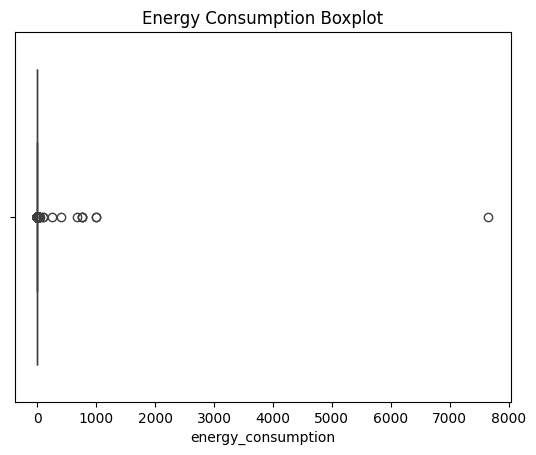

In [20]:
#showing data distribution before anomaly detection and treatment
energy_plot_before_AD = sns.boxplot(SEC_demand['energy_consumption'], orient = 'h')
energy_plot_before_AD.set_title('Energy Consumption Boxplot')


<ipython-input-21-c671d18eddcf>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  energy_dist_before_AD = sns.distplot(SEC_combined['energy_consumption'])


Text(0.5, 1.0, 'Energy Consumption Distribution')

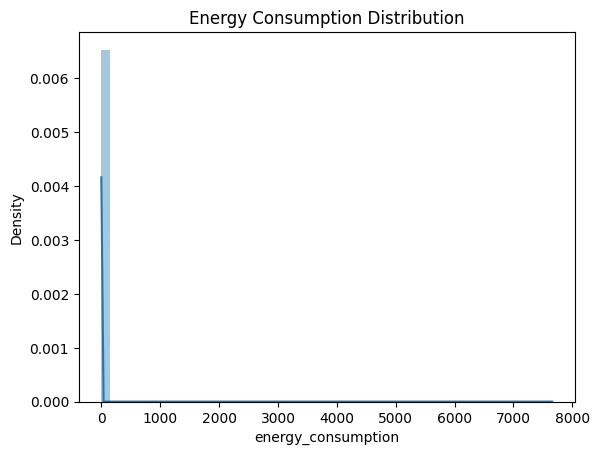

In [21]:
energy_dist_before_AD = sns.distplot(SEC_combined['energy_consumption'])
energy_dist_before_AD.set_title('Energy Consumption Distribution')

###Anomlay detection using IQR
Anomaly detection by region and site:
1. calculate IQR for each region and site
2. impute/treatment anomalies by the mean of each region and site on its own


---


In [22]:
#calculate IQR for each region and site
#Define a function for IQR-based anomaly detection and imputation
def detect_and_impute_anomalies(group):
    Q1 = group['energy_consumption'].quantile(0.25)
    Q3 = group['energy_consumption'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace anomalies with the region mean
    group['AD_energy_consumption'] = np.where((group['energy_consumption'] < lower_bound) | (group['energy_consumption'] > upper_bound), 1, 0)
    group['new_imputed_consumption'] = np.where(group['AD_energy_consumption'] == 1, np.mean(group['energy_consumption']), group['energy_consumption'])

    return group

In [23]:
# Apply the function to each region and site
SEC_demand = SEC_demand.groupby(['region', 'site_id']).apply(detect_and_impute_anomalies)

SEC_demand = SEC_demand.reset_index(drop=True)

<ipython-input-23-82ff6012e9aa>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  SEC_demand = SEC_demand.groupby(['region', 'site_id']).apply(detect_and_impute_anomalies)


In [24]:
#check the values
mean_energy_by_region_site = SEC_demand.groupby(['region', 'site_id'], as_index=False)['energy_consumption'].mean()
print(mean_energy_by_region_site)

   region site_id  energy_consumption
0       A       A            0.379399
1       A       C            0.602193
2       A       D            0.301384
3       A       E            0.252130
4       B       K            0.188917
5       B       L            0.271116
6       B       N            0.225875
7       B       P            0.190106
8       B       Q            0.172039
9       C       F            0.205649
10      C       G            0.326967
11      C       H            0.238747
12      C       J            0.206473
13      D       U            0.186330


In [25]:
#show to check
filtered_SEC_demand = SEC_demand[SEC_demand['AD_energy_consumption'] == 1]
print(filtered_SEC_demand[['region','site_id' ,'AD_energy_consumption', 'energy_consumption', 'new_imputed_consumption']].head(5))
print(filtered_SEC_demand[['region','site_id' ,'AD_energy_consumption', 'energy_consumption', 'new_imputed_consumption']].tail(5))

    region site_id  AD_energy_consumption  energy_consumption  \
80       A       A                      1               1.078   
137      A       A                      1               1.098   
230      A       A                      1               1.181   
280      A       A                      1               1.092   
375      A       A                      1               1.241   

     new_imputed_consumption  
80                  0.379399  
137                 0.379399  
230                 0.379399  
280                 0.379399  
375                 0.379399  
        region site_id  AD_energy_consumption  energy_consumption  \
1378921      D       U                      1               0.509   
1379064      D       U                      1               0.923   
1379108      D       U                      1               0.555   
1379204      D       U                      1               1.234   
1379205      D       U                      1               0.658   

        

<ipython-input-26-0f93f2d32378>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  energy_dist_after_AD = sns.distplot(SEC_demand['new_imputed_consumption'])


Text(0.5, 1.0, 'Energy Consumption Distribution After AD')

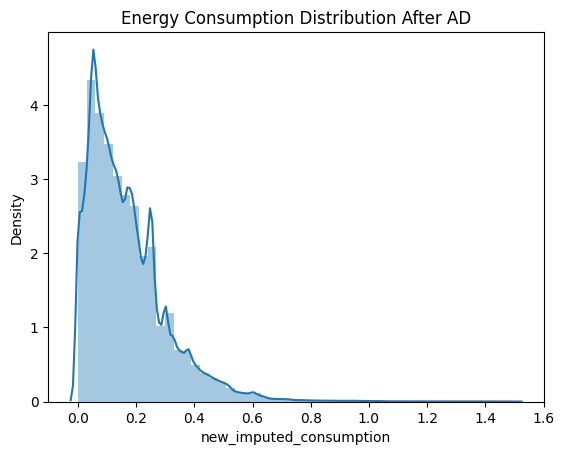

In [26]:
#Distribution and box plot after Anomaly detection and treatment
energy_dist_after_AD = sns.distplot(SEC_demand['new_imputed_consumption'])
energy_dist_after_AD.set_title('Energy Consumption Distribution After AD')

Text(0.5, 1.0, 'Energy Consumption boxplot After AD')

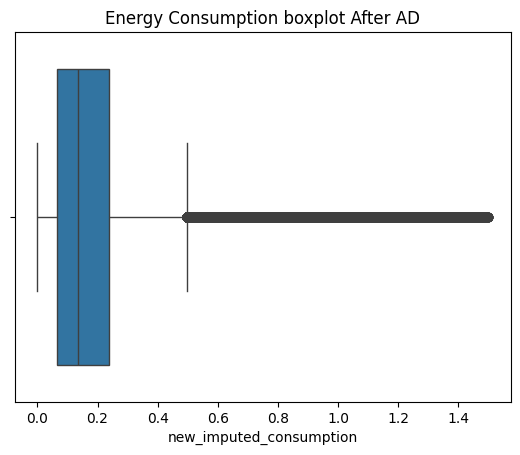

In [27]:
energy_box_after_AD=sns.boxplot(SEC_demand['new_imputed_consumption'], orient = 'h')
energy_box_after_AD.set_title('Energy Consumption boxplot After AD')


In [28]:
#check stats after AD
SEC_demand['new_imputed_consumption'].describe()

,new_imputed_consumption
count,1.379310e+06
mean,1.676523e-01
std,1.393789e-01
min,0.000000e+00
25%,6.500000e-02
50%,1.360000e-01
75%,2.380000e-01
max,1.500000e+00


In [29]:
#plot the stat of energy consumption

summary_stats = SEC_demand['new_imputed_consumption'].describe()

# Extracting the statistics

#drop count as it will mess with all other values and the plot will be meaningless
summary_stats = summary_stats.drop('count')

stats = summary_stats.index
values = summary_stats.values

# Create a bar plot for the summary statistics
fig = go.Figure()

# Add bar chart
fig.add_trace(go.Bar(
    x=stats,
    y=values,
    marker_color='skyblue',
    text=values,
    textposition='auto',
    name="Summary Statistics"
))

# Update layout for better visualization
fig.update_layout(
    title="Summary Statistics of Energy Consumption",
    xaxis_title="Statistics",
    yaxis_title="Values",
    template="plotly_white",
    xaxis=dict(categoryorder='array', categoryarray=stats)  # Keep the order consistent
)

# Show plot
fig.show()


###Feature engineering, Analysis and insights
---

In [30]:
#just showing cols names to copy and paste
SEC_demand.columns

Index(['cell_id', 'DateTime', 'energy_consumption', 'site_id', 'region',
       'Demand', 'AD_energy_consumption', 'new_imputed_consumption'],
      dtype='object')

###Analyze energy consumption per region to identify areas with the highest and lowest usage
---

In [31]:
# Create a pivot table to sum the energy consumption by region
region_consumption_pivot = SEC_demand.pivot_table(values='new_imputed_consumption', index='region', aggfunc='sum')

# Sort the regions by total energy consumption
region_consumption_pivot_sorted = region_consumption_pivot.sort_values(by='new_imputed_consumption', ascending=False)


region_consumption_pivot_sorted

,new_imputed_consumption
region,
A,98859.155792
C,66451.661068
B,61859.725726
D,4073.970527


Text(0, 0.5, 'Total Energy Consumption (KWH/hh)')

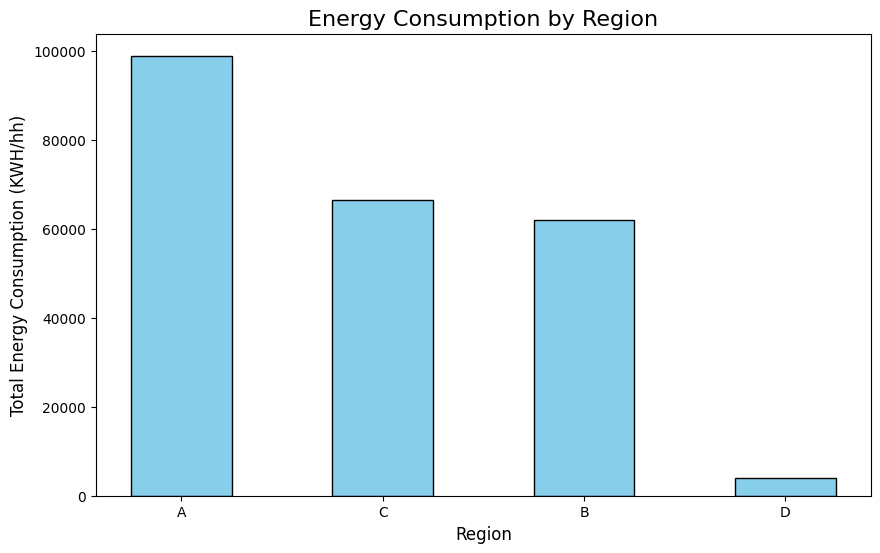

In [32]:
#bar plot by matplot lib
plt.figure(figsize=(10, 6))
plt.bar(region_consumption_pivot_sorted.index, region_consumption_pivot_sorted['new_imputed_consumption'], width = 0.5,
        color = 'skyblue', edgecolor = 'black')

# Set plot labels and title
plt.title('Energy Consumption by Region', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Total Energy Consumption (KWH/hh)', fontsize=12)

###Demand Analysis
---

In [33]:
# Create a pivot table to sum the energy consumption by demand level
demand_consumption_pivot = SEC_demand.pivot_table(values='new_imputed_consumption', index='Demand', aggfunc='sum')



Text(0, 0.5, 'Total Energy Consumption (KWH/hh)')

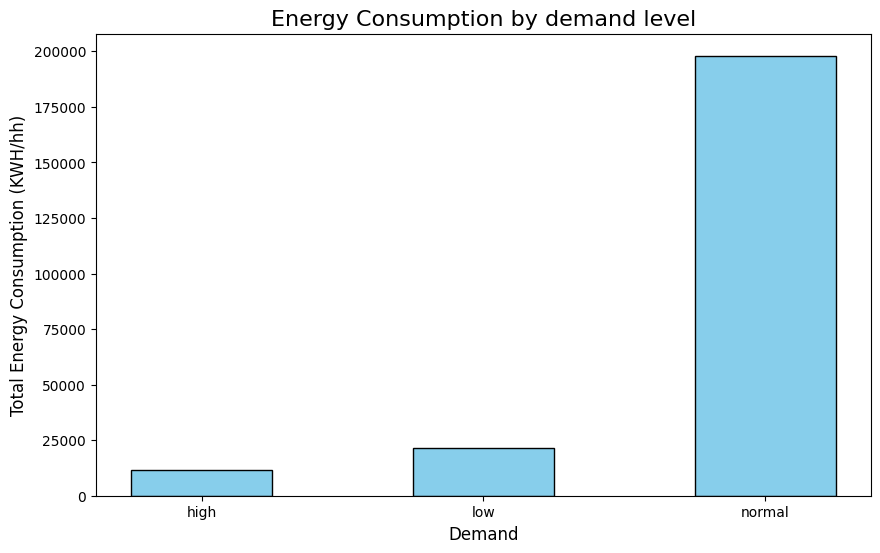

In [34]:
#bar plot by matplot lib
plt.figure(figsize=(10, 6))
plt.bar(demand_consumption_pivot.index, demand_consumption_pivot['new_imputed_consumption'], width = 0.5,
        color = 'skyblue', edgecolor = 'black')

# Set plot labels and title
plt.title('Energy Consumption by demand level', fontsize=16)
plt.xlabel('Demand', fontsize=12)
plt.ylabel('Total Energy Consumption (KWH/hh)', fontsize=12)

Text(0, 0.5, 'count')

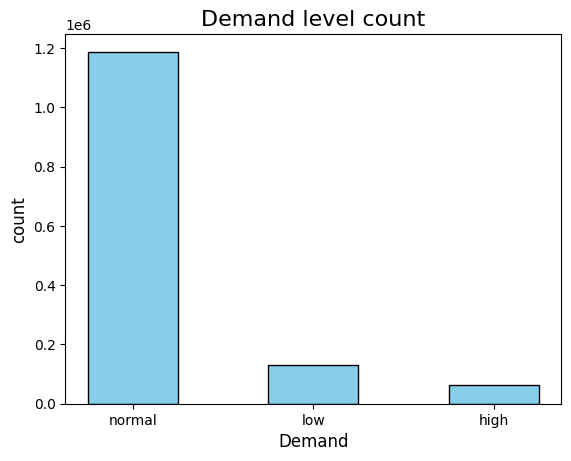

In [35]:
#Demand level count
demand_level_count = SEC_demand['Demand'].value_counts()
demand_level_count = pd.DataFrame(demand_level_count).reset_index()

plt.bar(demand_level_count['Demand'], demand_level_count['count'], width = 0.5,
        color = 'skyblue', edgecolor = 'black')

# Set plot labels and title
plt.title('Demand level count', fontsize=16)
plt.xlabel('Demand', fontsize=12)
plt.ylabel('count', fontsize=12)


In [36]:
#Demand level means
demand_level_means = SEC_demand.groupby('Demand')['new_imputed_consumption'].mean()
demand_level_means = pd.DataFrame(demand_level_means).reset_index()


In [37]:
#show
demand_level_means

,Demand,new_imputed_consumption
0,high,0.187443
1,low,0.166167
2,normal,0.166783


Text(0, 0.5, 'means')

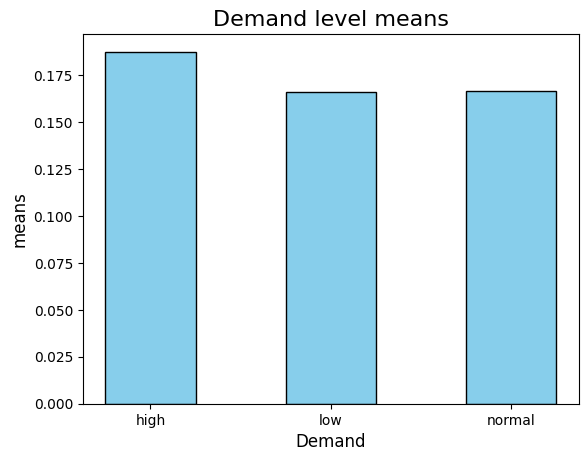

In [38]:
plt.bar(demand_level_means['Demand'], demand_level_means['new_imputed_consumption'], width = 0.5,
        color = 'skyblue', edgecolor = 'black')

# Set plot labels and title
plt.title('Demand level means', fontsize=16)
plt.xlabel('Demand', fontsize=12)
plt.ylabel('means', fontsize=12)

###Date time feature engineering: extract new features for further analysis
---

In [39]:
def create_features(df, datetime_col):
    """
    Create time series features based on the specified datetime column.
    """
    df = df.copy()
    df['hour'] = df[datetime_col].dt.hour
    df['dayofweek'] = df[datetime_col].dt.dayofweek
    df['month'] = df[datetime_col].dt.month
    df['year'] = df[datetime_col].dt.year
    df['dayofmonth'] = df[datetime_col].dt.day
    return df

# Apply the function
SEC_demand = create_features(SEC_demand,'DateTime' )

In [40]:
#check
SEC_demand.info()
SEC_demand.head()
SEC_demand[['DateTime', 'hour', 'year']]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379310 entries, 0 to 1379309
Data columns (total 13 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   cell_id                  1379310 non-null  object        
 1   DateTime                 1379310 non-null  datetime64[ns]
 2   energy_consumption       1379310 non-null  float64       
 3   site_id                  1379310 non-null  object        
 4   region                   1379310 non-null  object        
 5   Demand                   1379310 non-null  object        
 6   AD_energy_consumption    1379310 non-null  int64         
 7   new_imputed_consumption  1379310 non-null  float64       
 8   hour                     1379310 non-null  int32         
 9   dayofweek                1379310 non-null  int32         
 10  month                    1379310 non-null  int32         
 11  year                     1379310 non-null  int32         
 12  

,DateTime,hour,year
0,2013-01-01 00:00:00,0,2013
1,2013-01-01 00:30:00,0,2013
2,2013-01-01 01:00:00,1,2013
3,2013-01-01 01:30:00,1,2013
4,2013-01-01 02:00:00,2,2013
...,...,...,...
1379305,2013-12-31 21:30:00,21,2013
1379306,2013-12-31 22:00:00,22,2013
1379307,2013-12-31 22:30:00,22,2013
1379308,2013-12-31 23:00:00,23,2013


To visualize the relationship between the newly added features (like hour, day of the week, month, etc.) and energy consumption, box plots are a great choice. These plots will help us understand the distribution of energy consumption across different categories, allowing you to spot patterns, outliers, or trends.

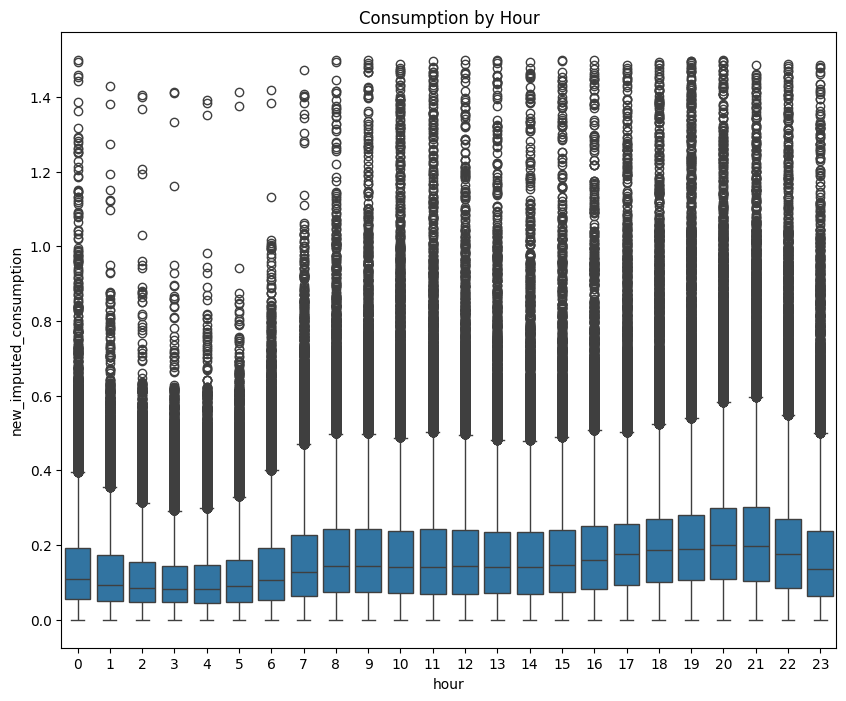

In [41]:
#hour and consumption
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=SEC_demand, x='hour', y='new_imputed_consumption')
ax.set_title('Consumption by Hour')
plt.show()

<ipython-input-42-6f5452ca947a>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




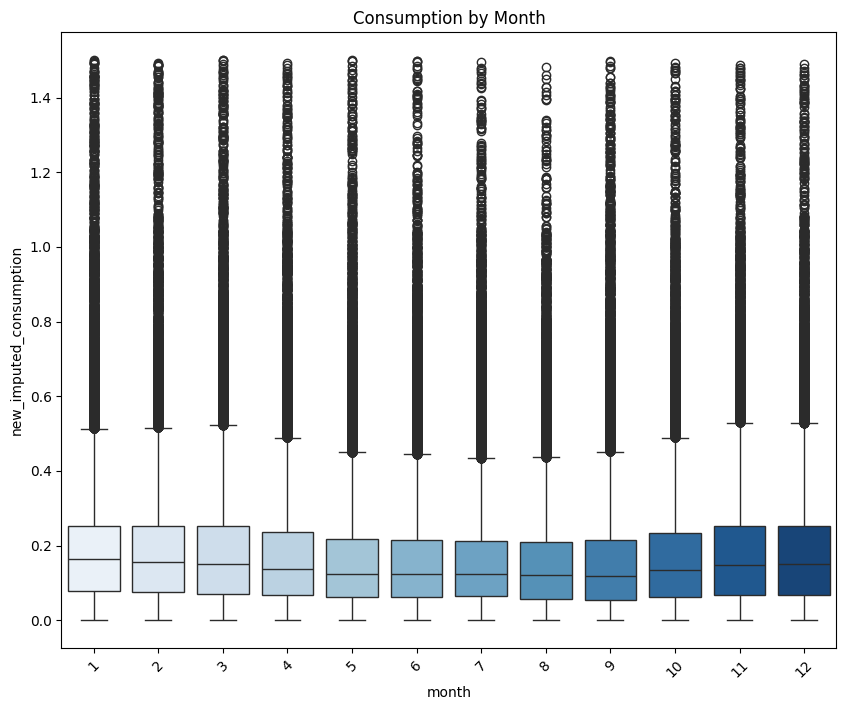

In [42]:
#month and consumption
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=SEC_demand, x='month', y='new_imputed_consumption', palette='Blues')
ax.set_title('Consumption by Month')
plt.xticks(rotation=45)

plt.show()

So far, we have insights about:
1. the higer and lower region
2. consumption by month, by hour, and by demand

###Now, we will filter for the highest average energy consumption hour in each region
---

In [43]:
# Group by Region and Hour, then calculate the mean consumption for each group
# we can also use pivot tables instead of group by(same result)

region_hour_consumption = SEC_demand.groupby(['region', 'hour'])['new_imputed_consumption'].mean().reset_index()

# Find the highest consumption hour for each region
max_consumption_hour_per_region = region_hour_consumption.loc[region_hour_consumption.groupby('region')['new_imputed_consumption'].idxmax()].reset_index(drop=True)

# Display the result
print(max_consumption_hour_per_region)


  region  hour  new_imputed_consumption
0      A    20                 0.227927
1      B    20                 0.194311
2      C    20                 0.256553
3      D    18                 0.148500


In [44]:
# Create a bar plot using plotly to make it more dynamic and interactive
fig = px.bar(max_consumption_hour_per_region,
             x='region',
             y='new_imputed_consumption',
             color='hour',
             title="Highest Consumption Hour by Region",
             labels={'new_imputed_consumption': 'Average Consumption (KWH)', 'hour': 'Hour of Day'},
             text='hour')

# Update layout for better readability
fig.update_layout(xaxis_title='Region',
                  yaxis_title='Average Consumption (KWH)',
                  xaxis={'categoryorder': 'category ascending'})

fig.show()


###From the above plot, we can conclude that the highest average energy consumption hours are observed during the evening, specifically between 6 PM and 8 PM.
---

###I will repeat the same process to find out the lowes hour in each region.
---

In [45]:
# Group by Region and Hour, then calculate the mean consumption for each group
region_hour_consumption = SEC_demand.groupby(['region', 'hour'])['new_imputed_consumption'].mean().reset_index()

# Find the highest consumption hour for each region
min_consumption_hour_per_region = region_hour_consumption.loc[region_hour_consumption.groupby('region')['new_imputed_consumption'].idxmin()].reset_index(drop=True)

# Display the result
print(min_consumption_hour_per_region)


  region  hour  new_imputed_consumption
0      A     3                 0.133548
1      B     3                 0.085120
2      C     3                 0.107785
3      D     3                 0.063111


now, I will repeat the plot for lowest hour

In [46]:
# Create a bar plot
fig = px.bar(min_consumption_hour_per_region,
             x='region',
             y='new_imputed_consumption',
             color='hour',
             title="Lowest Consumption Hour by Region",
             labels={'new_imputed_consumption': 'Average Consumption (KWH)', 'hour': 'Hour of Day'},
             text='hour')

# Update layout for better readability
fig.update_layout(xaxis_title='Region',
                  yaxis_title='Average Consumption (KWH)',
                  xaxis={'categoryorder': 'category ascending'})

fig.show()


###From the plot above, we can conclude that the lowest average energy consumption hours are observed during the early morning, specifically at 3am.
---

### Hypthesis testing
---

###Task description:

Validate the below assumptions using the corresponding statistical tests:
1. Does the region significantly affect energy consumption?
2. Is there a relationship between the time of day and energy consumption?
---

###Why anova test?
1. compare more than 2 groups.
2. The dataset contains continuous energy consumption values and categorical regions and times of day, which fits the ANOVA requirements.
---

###hypothesis test #1
----

###Writing hypotheses:
1. Null Hypothesis (H₀): The region does not significantly affect energy consumption.
2. Alternative Hypothesis (Ha): The region significantly affects energy consumption.

alpha  = 0.05

critria: if p-value < 0.05: reject Ho


In [47]:
# Perform ANOVA
anova_results = pg.anova(data=SEC_demand, dv='new_imputed_consumption', between='region')

# Display results
print(anova_results)

if anova_results['p-unc'][0] < 0.05:
    print("Significant differences found between regions.") #reject Ho
else:
    print("No significant differences found between regions.") #fail to reject Ho


   Source  ddof1    ddof2            F  p-unc       np2
0  region      3  1379306  10474.89773    0.0  0.022275
Significant differences found between regions.


###Hypothesis test #2
---

###Writing hypotheses:
1. Null Hypothesis (H₀): There is no relationship between the time of day and energy consumption.

2. Alternative Hypothesis (H₁): There is a relationship between the time of day and energy consumption.

apha = 0.05

critria: if p-value <0.05: reject Ho

###Find out that more feature engineering is needed to perform testing on time of day and consumption.
create new col(Time of day) as follows:
1. Morning: From 00:00:00 to 12:00:00.
2. Evening: From 13:00:00 to 18:00:00.
3.Night: From 19:00:00 to 23:59:59.

In [48]:
# Function to classify time of day
def classify_time_of_day(hour):
    if 0 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 19:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create the new feature
SEC_demand['Time_of_Day'] = SEC_demand['DateTime'].dt.hour.apply(classify_time_of_day)

# Display the updated DataFrame
#SEC_demand

In [49]:
#some checks
SEC_demand.info()
SEC_demand[['Time_of_Day', 'DateTime']]
SEC_demand['Time_of_Day'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379310 entries, 0 to 1379309
Data columns (total 14 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   cell_id                  1379310 non-null  object        
 1   DateTime                 1379310 non-null  datetime64[ns]
 2   energy_consumption       1379310 non-null  float64       
 3   site_id                  1379310 non-null  object        
 4   region                   1379310 non-null  object        
 5   Demand                   1379310 non-null  object        
 6   AD_energy_consumption    1379310 non-null  int64         
 7   new_imputed_consumption  1379310 non-null  float64       
 8   hour                     1379310 non-null  int32         
 9   dayofweek                1379310 non-null  int32         
 10  month                    1379310 non-null  int32         
 11  year                     1379310 non-null  int32         
 12  

,count
Time_of_Day,
Morning,689683
Evening,402272
Night,287355


In [50]:
# Perform ANOVA on 'Time_of_Day' col
anova_results = pg.anova(data=SEC_demand, dv='new_imputed_consumption', between='Time_of_Day')

# Display results
print(anova_results)

if anova_results['p-unc'][0] < 0.05:
    print("Reject the null hypothesis: There is a relationship between time of day and energy consumption.")
else:
    print("Fail to reject the null hypothesis: No relationship exists between time of day and energy consumption.")


        Source  ddof1    ddof2             F  p-unc       np2
0  Time_of_Day      2  1379307  23895.072037    0.0  0.033488
Reject the null hypothesis: There is a relationship between time of day and energy consumption.


In [51]:
# Perform ANOVA on 'hour' col
anova_results = pg.anova(data=SEC_demand, dv='new_imputed_consumption', between='hour')

# Display results
print(anova_results)

if anova_results['p-unc'][0] < 0.05:
    print("Reject the null hypothesis: There is a relationship between time of day(hour) and energy consumption.")
else:
    print("Fail to reject the null hypothesis: No relationship exists between time of day(hour) and energy consumption.")

  Source  ddof1    ddof2            F  p-unc       np2
0   hour     23  1379286  3813.958263    0.0  0.059796
Reject the null hypothesis: There is a relationship between time of day(hour) and energy consumption.


###Visualize the new features added
---

In [52]:
# Group by region and time of day, then calculate the mean consumption for each group
#TOD: time of day
region_TOD_consumption = SEC_demand.groupby(['region', 'Time_of_Day'])['new_imputed_consumption'].mean().reset_index()

# Display the result
print(region_TOD_consumption)

   region Time_of_Day  new_imputed_consumption
0       A     Evening                 0.192479
1       A     Morning                 0.162768
2       A       Night                 0.216328
3       B     Evening                 0.160270
4       B     Morning                 0.117283
5       B       Night                 0.171923
6       C     Evening                 0.196765
7       C     Morning                 0.150993
8       C       Night                 0.236616
9       D     Evening                 0.131870
10      D     Morning                 0.097056
11      D       Night                 0.140540


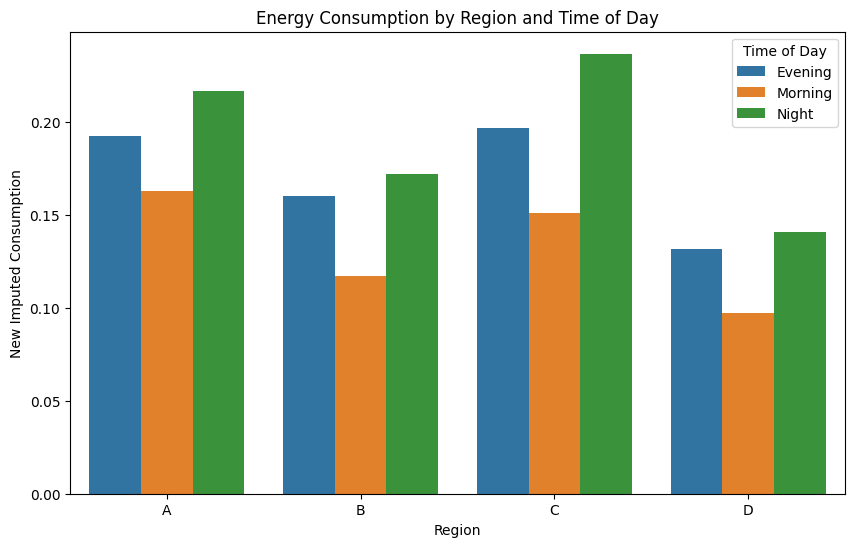

In [53]:


# Grouped Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='new_imputed_consumption', hue='Time_of_Day', data=region_TOD_consumption)
plt.title('Energy Consumption by Region and Time of Day')
plt.ylabel('New Imputed Consumption')
plt.xlabel('Region')
plt.legend(title='Time of Day')
plt.show()



###Task description:
Assuming that we can shutdown few cells were the consumption is low, what is the threshold that you would recommend and how much KW and EGP it would save accordingly?
---

###Threshold determination:
After research:

I found multiple common threshold determination processes:

1.quantiles/percentiles(5%, 10%, Q1, Q2, Q3)

2.below mean by std (1 std below mean , 2 std below mean, .., etc).

###Criteria (using percentiles method):
1. extract all records with demand level 'low'
2. Threshold = 10% of low records.(any consumption below 10% will be shutted down)

###How the percentile 10% is calculated:
np.percentile Function:

Part of the NumPy library, this function calculates the value below which a certain percentage of the data falls.
In this case, it finds the value below which 10% of the data in the energy_consumption column falls.






In [54]:
# Calculate the threshold (10th percentile)
SEC_low = SEC_demand[SEC_demand['Demand'] == 'low']

threshold = np.percentile(SEC_low['energy_consumption'], 10)
low_consumption_cells = SEC_demand[(SEC_demand['new_imputed_consumption'] < threshold)]

total_low_consumption = low_consumption_cells['new_imputed_consumption'].sum()
kw_savings = total_low_consumption
print('KWh saved by shutting down low consumption cells =' , kw_savings)

KWh saved by shutting down low consumption cells = 1539.6980000000003


In [ ]:
prices = {
    'high': 77.21,      # p/kWh for high demand
    'normal': 19.46,    # p/kWh for normal demand
    'low': 6.89         # p/kWh for low demand
}

# Create a new column 'price_level' based on 'Demand'
low_consumption_cells['price_level'] = low_consumption_cells['Demand'].map(prices)


In [57]:
low_consumption_cells.loc[:, 'total_cost'] = (
    low_consumption_cells['new_imputed_consumption'] * low_consumption_cells['price_level'] / 100
)

EGP_saved = low_consumption_cells['total_cost'].sum()
print('total cost saved by EGP = ', EGP_saved)


total cost saved by EGP =  313.3703416
